#### Human Protein Exploration

Using reference from this kernel https://www.kaggle.com/c/human-protein-atlas-image-classification/discussion/71039

In [ ]:
import torch

In [1]:
import fastai
fastai.__version__

'1.0.28'

In [2]:
from fastai import *
from fastai.torch_core import to_device, _default_device, _default_cpus
from fastai.vision import *
from fastai.vision.image import *
import torch
import torch.nn as nn
import torchvision
import cv2
import scipy.optimize as opt

In [3]:
np.random.seed(42)

In [4]:
path = Path('data')

In [5]:
# path.ls()

In [6]:
train_df = pd.read_csv(path / 'train.csv')

In [7]:
train_df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [8]:
RESNET_ENCODERS = {
    34: torchvision.models.resnet34,
    50: torchvision.models.resnet50,
    101: torchvision.models.resnet101,
    152: torchvision.models.resnet152,
}

In [9]:
class Resnet4Channel(nn.Module):
    
    def __init__(self, encoder_depth=34, pretrained=True, num_classes=28):
        super().__init__()
        encoder = RESNET_ENCODERS[encoder_depth](pretrained=pretrained)
        w = encoder.conv1.weight
        
#         (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
#         (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
#         (relu): ReLU(inplace)
#         (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.conv1 = nn.Conv2d(4, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.conv1.weight = nn.Parameter(torch.cat((w, torch.zeros(64, 1, 7, 7)), dim=1))
        self.bn1 = encoder.bn1
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
        self.layer4 = encoder.layer4
        
        self.avgpool = encoder.avgpool
        self.fc = nn.Linear(512 * (1 if encoder_depth == 34 else 4), num_classes)
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [10]:
def open_4_channel(fname):
    fname = str(fname)
    if fname.endswith(".png"):
        fname = fname[:-4]
        
    colors = ['red', 'green', 'blue', 'yellow']
    flags = cv2.IMREAD_GRAYSCALE
    
    img = [cv2.imread(fname + '_' + color + '.png', flags).astype(np.float32) / 255 for color in colors]
    
    x = np.stack(img, axis=-1)
    
    return Image(pil2tensor(x, np.float32).float())

In [11]:
src = (ImageItemList.from_csv(path, 'train.csv', folder='train', suffix='.png')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [12]:
src.train.x.open = open_4_channel
src.train.x.create_func = open_4_channel

In [13]:
src.valid.x.open = open_4_channel
src.valid.x.create_func = open_4_channel

In [14]:
test_ids = list(sorted(set(fname.split('_')[0] for fname in os.listdir(path / 'test'))))

In [15]:
test_fnames = [path/'test'/test_id for test_id in test_ids]

In [16]:
test_fnames[:5]

[PosixPath('data/test/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/test/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/test/0008baca-bad7-11e8-b2b9-ac1f6b6435d0'),
 PosixPath('data/test/000cce7e-bad4-11e8-b2b8-ac1f6b6435d0')]

In [17]:
src.add_test(test_fnames, label='0');

In [18]:
src.test.x.open = open_4_channel
src.test.x.create_func = open_4_channel

In [19]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [20]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30., max_zoom=1, max_lighting=0.05, max_warp=0.)

In [21]:
data = (src.transform((trn_tfms, _), size=512).databunch(bs=2).normalize(protein_stats))

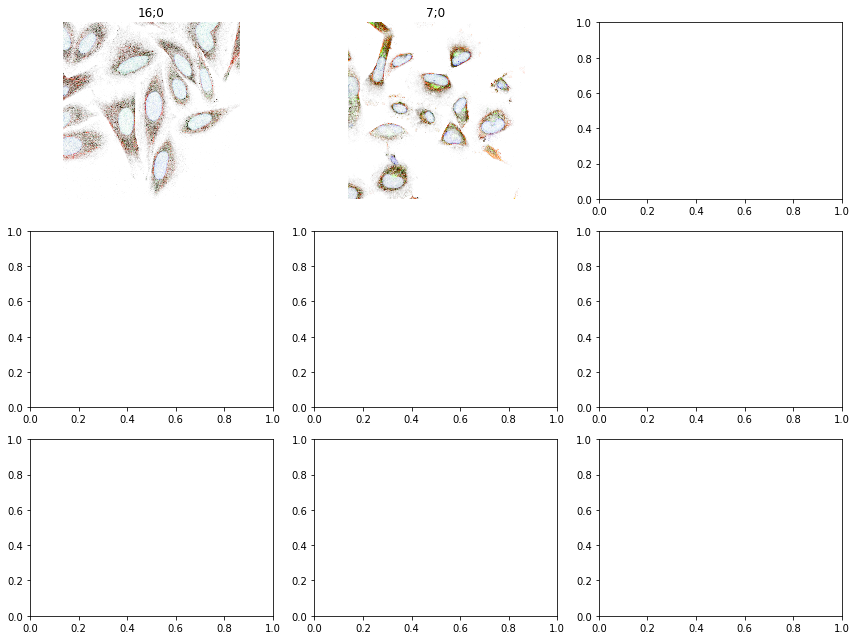

In [22]:
data.show_batch(rows=3, figsize=(12,9))

In [23]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [24]:
def resnet101(pretrained):
    return Resnet4Channel(encoder_depth=101)

In [25]:
def resnet152(pretrained):
    return Resnet4Channel(encoder_depth=152)

In [26]:
def _resnet_split(m): return (m[0][6],m[1])

In [27]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

#### Resnet 101 - 512

In [27]:
learn = create_cnn(
    data,
    resnet101,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [28]:
# learn.save("unfreeze_386_resnet101")
# learn.save("unfreeze_386_resnet101-2")

# learn.save("unfreeze_512_resnet101")
# learn.save("unfreeze_512_resnet101-2")
# learn.save("unfreeze_512_resnet101-3")

In [29]:
_ = learn.load("unfreeze_512_resnet101")

In [30]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

Total time: 1:15:06



In [36]:
avg_pred.shape

torch.Size([11702, 28])

In [43]:
tmp_avg_preds = np.array(avg_pred)

In [82]:
avg_preds_df = pd.DataFrame(tmp_avg_preds)
test_ids_series = pd.DataFrame(test_ids,columns=['ids'])
output_df = pd.concat([test_ids_series, avg_preds_df], axis=1)

In [92]:
output_df.to_csv(path/'ensameble_probs_tmp-1_resnet101_512_avg_preds_v1.csv', header=True, index=False)

#### Resnet 152 - 512

In [28]:
learn = create_cnn(
    data,
    resnet152,
    cut=-2,
    split_on=_resnet_split,
    loss_func=F.binary_cross_entropy_with_logits,
    path=path,    
    metrics=[f1_score], 
)

In [29]:
_ = learn.load("freeze_512_resnet152")

RuntimeError: CUDA out of memory. Tried to allocate 2.25 MiB (GPU 0; 15.90 GiB total capacity; 265.21 MiB already allocated; 2.88 MiB free; 2.04 MiB cached)

In [30]:
preds, avg_pred, y = learn.TTA(beta=None, scale=1.05, ds_type=DatasetType.Test)

Total time: 1:15:06



In [36]:
avg_pred.shape

torch.Size([11702, 28])

In [43]:
tmp_avg_preds = np.array(avg_pred)

In [82]:
avg_preds_df = pd.DataFrame(tmp_avg_preds)
test_ids_series = pd.DataFrame(test_ids,columns=['ids'])
output_df = pd.concat([test_ids_series, avg_preds_df], axis=1)

In [92]:
output_df.to_csv(path/'ensameble_probs_tmp-2_resnet152_512_avg_preds_v1.csv', header=True, index=False)